In [133]:
import os
import pandas as pd
import glob
from PIL import Image
import numpy as np

In [175]:
# Paths to your folders
main_folder = '/Users/laurabreimann/Documents/Postdoc/Colabs/PLA_Christine/Duolink_assay_2023_Nov-Dec/puro-PLA/tiffs'               
localization_folders = ['/Users/laurabreimann/Documents/Postdoc/Colabs/PLA_Christine/Duolink_assay_2023_Nov-Dec/puro-PLA/70um_neurite_counts',  
                        '/Users/laurabreimann/Documents/Postdoc/Colabs/PLA_Christine/Duolink_assay_2023_Nov-Dec/puro-PLA/soma_counts']
output_database = '/Users/laurabreimann/Documents/Postdoc/Colabs/PLA_Christine/Duolink_assay_2023_Nov-Dec/database/PLA_database.csv'   


In [176]:
# List to hold all the row data
data_rows = []

In [177]:
# Traverse the main folder
for gene in os.listdir(main_folder):
    gene_path = os.path.join(main_folder, gene)
    if os.path.isdir(gene_path):
        for file in os.listdir(gene_path):
            if file.endswith('_C3.tif'):
                # Remove the _C3.tif to get the stem for matching
                filename_stem = file[:-7]
                # Check each localization folder for corresponding CSV files
                for loc_folder in localization_folders:
                    # Create a pattern for glob to match CSV files
                    loc_pattern = os.path.join(loc_folder, filename_stem.replace(' ', '_') + '*.csv')
                    csv_files = glob.glob(loc_pattern)
                    print(f"Looking for CSVs with path: {loc_pattern}")  # Debugging output
                    print(f"Found CSV files: {csv_files}")  # Debugging output
                    for csv_file in csv_files:
                        # Extract the unique part of the CSV filename that differs from the stem
                        unique_part = os.path.basename(csv_file).replace(filename_stem.replace(' ', '_'), '').replace('.csv', '')
                        loc_data = pd.read_csv(csv_file)
                        # Create a new row for each CSV file found
                        row = {
                            'Gene': gene,
                            'Filename': filename_stem + unique_part,
                            os.path.basename(loc_folder) + '_localizations': len(loc_data)
                        }
                        data_rows.append(row)

# Create DataFrame from the list of dictionaries
database = pd.DataFrame(data_rows)

# Save the database to a CSV file
database.to_csv(output_database, index=False)

Looking for CSVs with path: /Users/laurabreimann/Documents/Postdoc/Colabs/PLA_Christine/Duolink_assay_2023_Nov-Dec/puro-PLA/70um_neurite_counts/EpHA4_Puromycin_13-11-23.lif_-_273-12*.csv
Found CSV files: ['/Users/laurabreimann/Documents/Postdoc/Colabs/PLA_Christine/Duolink_assay_2023_Nov-Dec/puro-PLA/70um_neurite_counts/EpHA4_Puromycin_13-11-23.lif_-_273-12_filtered_localizations.csv']
Looking for CSVs with path: /Users/laurabreimann/Documents/Postdoc/Colabs/PLA_Christine/Duolink_assay_2023_Nov-Dec/puro-PLA/soma_counts/EpHA4_Puromycin_13-11-23.lif_-_273-12*.csv
Found CSV files: ['/Users/laurabreimann/Documents/Postdoc/Colabs/PLA_Christine/Duolink_assay_2023_Nov-Dec/puro-PLA/soma_counts/EpHA4_Puromycin_13-11-23.lif_-_273-12_filtered_localizations.csv']
Looking for CSVs with path: /Users/laurabreimann/Documents/Postdoc/Colabs/PLA_Christine/Duolink_assay_2023_Nov-Dec/puro-PLA/70um_neurite_counts/EpHA4_Puromycin_13-11-23.lif_-_273-3*.csv
Found CSV files: ['/Users/laurabreimann/Documents/Po

In [178]:
# Load the existing database CSV
database_df = pd.read_csv('/Users/laurabreimann/Documents/Postdoc/Colabs/PLA_Christine/Duolink_assay_2023_Nov-Dec/database/PLA_database.csv')  # Replace with the path to your database CSV

# Group by 'Gene' and 'Filename', then combine using the 'first' non-null value
# If columns are numeric and should be summed instead of taking the 'first', replace 'first' with 'sum'
cleaned_df = database_df.groupby(['Gene', 'Filename'], as_index=False).first()

# Save the cleaned-up database to a new CSV file
cleaned_df.to_csv('/Users/laurabreimann/Documents/Postdoc/Colabs/PLA_Christine/Duolink_assay_2023_Nov-Dec/database/PLA_database_cleaned.csv', index=False)

In [179]:
cleaned_df.head()

Gene                                           Filename  \
0  EpHA4  EpHA4_Puromycin_13-11-23.lif_-_273-10_filtered...   
1  EpHA4  EpHA4_Puromycin_13-11-23.lif_-_273-11_1_filter...   
2  EpHA4  EpHA4_Puromycin_13-11-23.lif_-_273-11_filtered...   
3  EpHA4  EpHA4_Puromycin_13-11-23.lif_-_273-12_filtered...   
4  EpHA4  EpHA4_Puromycin_13-11-23.lif_-_273-13_filtered...   

   70um_neurite_counts_localizations  soma_counts_localizations  
0                              148.0                      192.0  
1                              180.0                      157.0  
2                              120.0                      168.0  
3                               79.0                      148.0  
4                               52.0                       62.0

In [180]:
# Paths to your folders
soma_mask_folder = '/Users/laurabreimann/Documents/Postdoc/Colabs/PLA_Christine/Duolink_assay_2023_Nov-Dec/masks/soma_masks'  
neurite_mask_folder = '/Users/laurabreimann/Documents/Postdoc/Colabs/PLA_Christine/Duolink_assay_2023_Nov-Dec/masks/70um_neurite_mask'  


In [181]:

# Function to count non-zero pixels in a mask
def count_nonzero_pixels(mask_path):
    mask_image = Image.open(mask_path)
    mask_array = np.array(mask_image)
    return np.count_nonzero(mask_array)

In [182]:

for index, row in cleaned_df.iterrows():
    # Start with the filename from the DataFrame
    filename_stem = row['Filename']
    
    # First, let's remove the "_filtered_localizations" part as it's not part of the mask filename
    filename_stem = filename_stem.replace('_filtered_localizations', '')
    
    # Replace spaces and dots with underscores, but keep the structure like "13-11-23.lif -"
    # Based on the example file provided, let's create a pattern that matches it
    mask_search_stem = filename_stem

    # Debugging: Print the filename stem being used for search
    print(f"Filename stem for searching: {mask_search_stem}")

    # Check both mask folders
    for mask_folder, mask_type in zip([soma_mask_folder, neurite_mask_folder], ['soma', 'neurite']):
        # Construct the search pattern
        search_pattern = os.path.join(mask_folder, mask_search_stem + '_*')
        mask_files = glob.glob(search_pattern)
        
        # Debugging print statements
        print(f"Search pattern: {search_pattern}")
        print(f"Found mask files: {mask_files}")

        if mask_files:
            # Assume the first file is the correct one
            mask_size = count_nonzero_pixels(mask_files[0])
            cleaned_df.loc[index, mask_type + '_mask_size'] = mask_size
        else:
            # If no mask file is found, set the size to NaN
            cleaned_df.loc[index, mask_type + '_mask_size'] = np.nan

# Save the updated DataFrame to a new CSV file
cleaned_df.to_csv('/Users/laurabreimann/Documents/Postdoc/Colabs/PLA_Christine/Duolink_assay_2023_Nov-Dec/database/PLA_database_cleaned_area.csv', index=False)  

Filename stem for searching: EpHA4_Puromycin_13-11-23.lif_-_273-10
Search pattern: /Users/laurabreimann/Documents/Postdoc/Colabs/PLA_Christine/Duolink_assay_2023_Nov-Dec/masks/soma_masks/EpHA4_Puromycin_13-11-23.lif_-_273-10_*
Found mask files: ['/Users/laurabreimann/Documents/Postdoc/Colabs/PLA_Christine/Duolink_assay_2023_Nov-Dec/masks/soma_masks/EpHA4_Puromycin_13-11-23.lif_-_273-10_GFP_max_segmentation_soma.tif']
Search pattern: /Users/laurabreimann/Documents/Postdoc/Colabs/PLA_Christine/Duolink_assay_2023_Nov-Dec/masks/70um_neurite_mask/EpHA4_Puromycin_13-11-23.lif_-_273-10_*
Found mask files: ['/Users/laurabreimann/Documents/Postdoc/Colabs/PLA_Christine/Duolink_assay_2023_Nov-Dec/masks/70um_neurite_mask/EpHA4_Puromycin_13-11-23.lif_-_273-10_GFP_max_segmentation.tif']
Filename stem for searching: EpHA4_Puromycin_13-11-23.lif_-_273-11_1
Search pattern: /Users/laurabreimann/Documents/Postdoc/Colabs/PLA_Christine/Duolink_assay_2023_Nov-Dec/masks/soma_masks/EpHA4_Puromycin_13-11-23.li

In [183]:
# Calculate the normalized neurite count
cleaned_df['neurite_count_norm'] = cleaned_df['70um_neurite_counts_localizations'] / cleaned_df['neurite_mask_size']

# Calculate the normalized soma count
cleaned_df['soma_count_norm'] = cleaned_df['soma_counts_localizations'] / cleaned_df['soma_mask_size']


# Define the function to determine the cell line
def determine_cell_line(filename):
    if '273' in filename:
        return 'wt'
    elif '277' in filename:
        return 'mutant'
    else:
        return 'unknown'  

# Define the function to check for anisomycin in the filename
def check_anisomycin(filename):
    return 1 if 'anisomycin' in filename.lower() else 0

# Apply the functions to the 'Filename' column to create the new columns
cleaned_df['cell line'] = cleaned_df['Filename'].apply(determine_cell_line)
cleaned_df['anisomycin'] = cleaned_df['Filename'].apply(check_anisomycin)


# Save the updated DataFrame to a new CSV file
cleaned_df.to_csv('/Users/laurabreimann/Documents/Postdoc/Colabs/PLA_Christine/Duolink_assay_2023_Nov-Dec/database/PLA_database_cleaned_area_norm.csv', index=False)
cleaned_df.head()


Gene                                           Filename  \
0  EpHA4  EpHA4_Puromycin_13-11-23.lif_-_273-10_filtered...   
1  EpHA4  EpHA4_Puromycin_13-11-23.lif_-_273-11_1_filter...   
2  EpHA4  EpHA4_Puromycin_13-11-23.lif_-_273-11_filtered...   
3  EpHA4  EpHA4_Puromycin_13-11-23.lif_-_273-12_filtered...   
4  EpHA4  EpHA4_Puromycin_13-11-23.lif_-_273-13_filtered...   

   70um_neurite_counts_localizations  soma_counts_localizations  \
0                              148.0                      192.0   
1                              180.0                      157.0   
2                              120.0                      168.0   
3                               79.0                      148.0   
4                               52.0                       62.0   

   soma_mask_size  neurite_mask_size  neurite_count_norm  soma_count_norm  \
0         21373.0            31690.0            0.004670         0.008983   
1         12348.0            20434.0            0.008809         0.012715   
2         12800.0            36325.0            0.003304         0.013125   
3         17626.0            28624.0            0.002760         0.008397   
4         17992.0            23230.0            0.002238         0.003446   

  cell line  anisomycin  
0        wt           0  
1        wt           0  
2        wt           0  
3        wt           0  
4        wt           0

In [184]:
import seaborn as sns
import matplotlib.pyplot as plt

In [185]:
# List of filename stems to exclude
filenames_to_exclude = ["EpHA4_Puromycin_13-11-23.lif_-_273-14",]

# Exclude rows that contain any of the filename stems
mask = cleaned_df['Filename'].apply(lambda x: any(stem in x for stem in filenames_to_exclude))
filtered_df = cleaned_df[~mask]
filtered_df.head()


Gene                                           Filename  \
0  EpHA4  EpHA4_Puromycin_13-11-23.lif_-_273-10_filtered...   
1  EpHA4  EpHA4_Puromycin_13-11-23.lif_-_273-11_1_filter...   
2  EpHA4  EpHA4_Puromycin_13-11-23.lif_-_273-11_filtered...   
3  EpHA4  EpHA4_Puromycin_13-11-23.lif_-_273-12_filtered...   
4  EpHA4  EpHA4_Puromycin_13-11-23.lif_-_273-13_filtered...   

   70um_neurite_counts_localizations  soma_counts_localizations  \
0                              148.0                      192.0   
1                              180.0                      157.0   
2                              120.0                      168.0   
3                               79.0                      148.0   
4                               52.0                       62.0   

   soma_mask_size  neurite_mask_size  neurite_count_norm  soma_count_norm  \
0         21373.0            31690.0            0.004670         0.008983   
1         12348.0            20434.0            0.008809         0.012715   
2         12800.0            36325.0            0.003304         0.013125   
3         17626.0            28624.0            0.002760         0.008397   
4         17992.0            23230.0            0.002238         0.003446   

  cell line  anisomycin  
0        wt           0  
1        wt           0  
2        wt           0  
3        wt           0  
4        wt           0

In [186]:
# Map the 'cell line' and 'anisomycin' to the new group labels
def map_to_group(row):
    if row['cell line'] == 'wt' and row['anisomycin'] == 0:
        return 'WT'
    elif row['cell line'] == 'wt' and row['anisomycin'] == 1:
        return 'Anisomycin'
    elif row['cell line'] == 'mutant':
        return 'Mutant'
    else:
        return 'Other'  # Use this if there are other types that don't fit the criteria


# Create the new 'group' column
filtered_df['group'] = filtered_df.apply(map_to_group, axis=1)

/var/folders/n4/82zt36bj3190s97jwk9jxc580000gn/T/ipykernel_36272/3092836890.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['group'] = filtered_df.apply(map_to_group, axis=1)


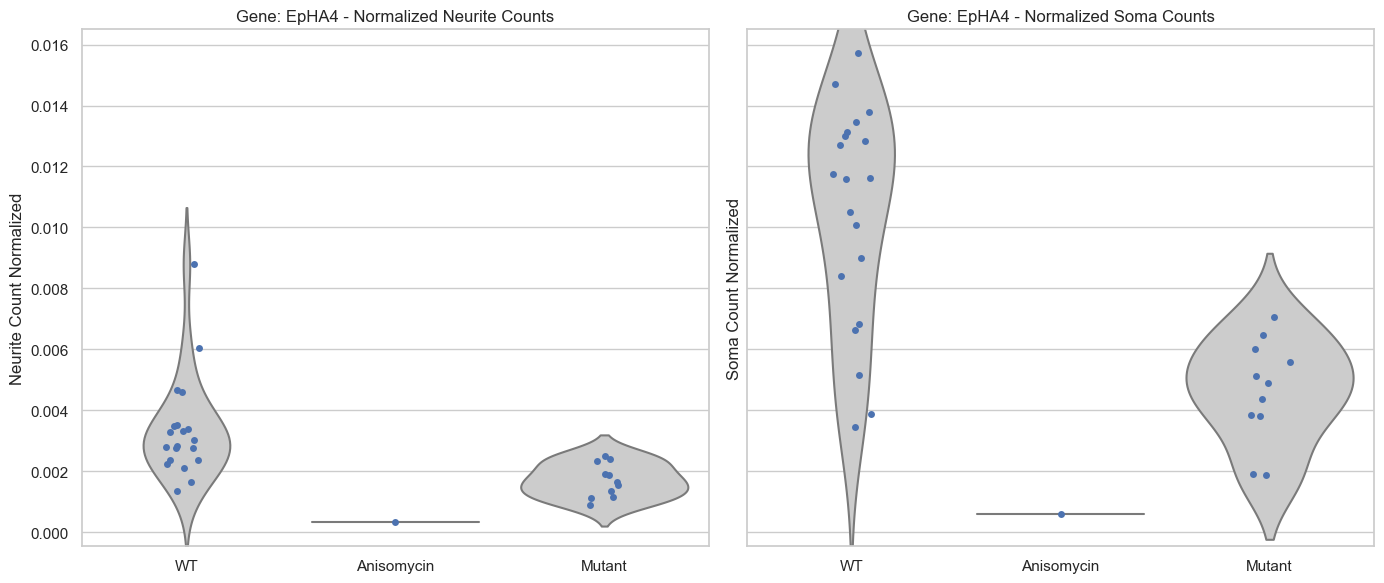

In [187]:
# Now plot with the 'group' column as the x-axis
sns.set(style="whitegrid")
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# Neurite count normalized plot
sns.violinplot(x="group", y="neurite_count_norm", data=filtered_df, inner=None, ax=axes[0], color=".8")
sns.stripplot(x="group", y="neurite_count_norm", data=filtered_df, jitter=True, ax=axes[0])
axes[0].set_title('Gene: EpHA4 - Normalized Neurite Counts')

# Soma count normalized plot
sns.violinplot(x="group", y="soma_count_norm", data=filtered_df, inner=None, ax=axes[1], color=".8")
sns.stripplot(x="group", y="soma_count_norm", data=filtered_df, jitter=True, ax=axes[1])
axes[1].set_title('Gene: EpHA4 - Normalized Soma Counts')

# Final touches
axes[0].set_xlabel('')
axes[1].set_xlabel('')
axes[0].set_ylabel('Neurite Count Normalized')
axes[1].set_ylabel('Soma Count Normalized')

plt.tight_layout()
plt.show()
